In [53]:
import collections
import networkx as nx
import numpy as np
import os
import random
from sklearn import linear_model
import json as json

In [54]:
# plot settings
import matplotlib.pyplot as plt

FIGSIZE_TWOCOL = (10,5)
FIGSIZE_ONECOL = (5,5)

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size= SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize= MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize= MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Statistiche generali

In [4]:
g = nx.read_edgelist('../network/networks/edge_list.txt',
                     create_using=nx.DiGraph(), nodetype=int, data=False)

In [5]:
# Erdos-Renyi random network
g_er = nx.read_edgelist('../network/networks/er_edge_list.txt',
                                create_using=nx.DiGraph(), nodetype=int,
                                data=False)

In [6]:
# Barabasi-Albert network
g_ba = nx.read_edgelist('../network/networks/ba_edge_list.txt',
                        create_using=nx.Graph(), nodetype=int,
                        data=False)


In [72]:
def network_summary(g, directed=True):
    """ returns dictionary with the network informations"""

    if(directed):
        """undirected graph statistics for directed graph, 
        NOTE: reciprocal links are lost"""
        g_und = g.to_undirected()
    else:
        g_und = g
        
    g_info= {}
    g_info['N'] = nx.number_of_nodes(g)
    g_info['L'] = nx.number_of_edges(g)

    degrees_und = [d for n,d in g_und.degree()]

    g_info['d_avg_und'] = int(np.mean(degrees_und))
    g_info['d_max_und'] = np.max(degrees_und)
    g_info['d_min_und'] = np.min(degrees_und)

    if(directed):
        
        in_degrees = [d for n, d in g.in_degree()]
        out_degrees = [d for n, d in g.out_degree()]
        degrees = [d for n,d in g.degree()]

        g_info['d_avg'] = int(np.mean(in_degrees))
        g_info['d_in_max'] = np.max(in_degrees)
        g_info['d_in_min'] = np.min(in_degrees)
        g_info['d_out_max'] = np.max(out_degrees)
        g_info['d_out_min'] = np.min(out_degrees)
        g_info['d_max'] = np.max(degrees)
        g_info['d_min'] = np.min(degrees)

        
    return g_info

In [73]:
g_info = network_summary(g, directed = True)

In [74]:
g_er_info = network_summary(g_er, directed = True)

In [30]:
g_ba_info = network_summary(g_ba , directed = False)

In [ ]:
infos = {'g':g_info, 'g_er':g_er_info , 'g_ba':g_ba_info }

In [36]:
with open("network_infos.json", 'w') as f:
    f.write(json.dumps(infos, indent =4) )    

In [10]:
## choosing erdos-renyi probability
probER=float(g_info['d_avg_und'])/(g_info['N'])
probER

0.0008671971275996896

- The network is sparse?

In [62]:
N = g_info['N']
L = g_info['L']
L_max = N*(N-1)/2
float(L)/L_max

0.001158157640820872

# Degree distribution

Questions:
- chi sono gli users che hanno il valore massimo di degree entrante/uscente?
- che caratteristiche in comune hanno?


In [76]:
in_degrees = [d for n, d in g.in_degree()]
out_degrees = [d for n, d in g.out_degree()]
degrees =[d for n,d in g.degree()]

# ordinamento
in_degrees.sort(reverse=True)
out_degrees.sort(reverse=True)
degrees.sort(reverse=True)

temp = [d for d in in_degrees if d ==0]
print len(temp)
print in_degrees[:10]

12939
[19064, 14629, 13129, 12200, 10744, 10211, 9677, 8892, 8514, 7594]


In [77]:
# in degree
in_degree_counts = collections.Counter(d for n, d in g.in_degree())
"""
for n, d in g.in_degree():
    print (n,d)
"""
in_degree_counts = [in_degree_counts.get(i, 0) for i in range(max(in_degree_counts) + 1) ]
degree_in= np.arange(len(in_degree_counts))
in_degree_probs = np.array(in_degree_counts).astype(float)/g_info['N']
print len(degree_in)
print len(in_degree_probs)

19065
19065


In [78]:
# out degree
out_degree_counts = collections.Counter(d for n, d in g.out_degree())
out_degree_counts = [out_degree_counts.get(i, 0) for i in range(max(out_degree_counts) + 1)]
degree_out= np.arange(len(out_degree_counts))
out_degree_probs = np.array(out_degree_counts).astype(float)/g_info['N']


## Logarithmic binning

In [183]:
degrees = [d for n,d in g.in_degree()]
##degrees.sort(reverse=False)
""" computing breaks """
b = 2 # 2
k=0
breaks=[]
while(b**(k-1)< max(degrees)):
    breaks.append(b**k)
    k+=1
#print breaks    

splitted_degrees = {}
for br in breaks:
    splitted_degrees[br]=[]

# splitting the degrees using the breaks
for d in degrees:
    i=1
    while(d>breaks[i]):
        i+=1
    splitted_degrees[breaks[i-1]].append(d)  

d_counts = {}
for br in breaks:
    d_counts[br]=[]

for br in breaks:
    d_counts[br] = len(splitted_degrees[br])
    
#print d_counts.keys()    
#print d_counts.values()

counts = [d_counts[br] for br in breaks]
degree_probs = np.array(counts).astype(float)/np.array(breaks)
degree_means = [ np.mean(np.array(splitted_degrees[br])) for br in breaks ]

# splitted_degrees
# print breaks
# print counts
print degree_probs
print degree_means

[  2.67670000e+04   3.29600000e+03   1.81425000e+03   8.46875000e+02
   3.81000000e+02   1.55375000e+02   5.45156250e+01   1.63281250e+01
   3.91406250e+00   8.24218750e-01   1.72851562e-01   2.78320312e-02
   5.85937500e-03   9.76562500e-04   6.10351562e-05   0.00000000e+00]
[0.71132364478649079, 3.427639563106796, 6.2979192503789445, 11.987158671586716, 23.298392388451443, 45.842719227674976, 90.653768988248785, 178.81291866028707, 355.02994011976045, 686.45260663507111, 1360.0056497175142, 2720.6842105263158, 5206.458333333333, 10999.5, 19064.0, nan]


In [90]:
counts = [ [b,0] for b in breaks]

for d in degrees:
    i=0
    while(d>breaks[i]):
        i+=1
    counts[i][1] += 1
    
print counts

print degrees[-10:]


[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
[[1, 0], [2, 0], [4, 0], [8, 0], [16, 0], [32, 0], [64, 0], [128, 42803], [256, 17023], [512, 4321], [1024, 1133], [2048, 360], [4096, 89]]
[76, 76, 76, 76, 76, 76, 76, 76, 76, 76]


In [85]:
x_counts = [x[0] for x in counts]
y_counts = np.array([y[1] for y in counts])/np.array(x_counts)
y_counts = [y for y in y_counts if y>0]
x_counts = range(len(y_counts))
#print y_counts[:10]
#print min(y_counts)
#print max(y_counts)
print len(x_counts)
print len(y_counts)
print min(x_counts)
print min(y_counts)

4
4
0
1


2.39
1.3


[]

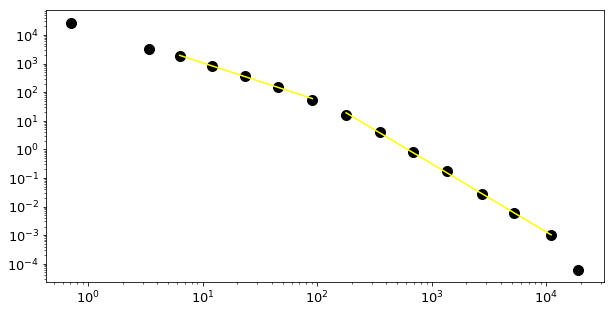

In [179]:
fig, ax = plt.subplots(figsize=FIGSIZE_TWOCOL)
MARKERSIZE=20

# random networks
#plt.plot(er_degree, er_degree_probs, '.', color='deeppink',   label=u'Erdős–Rényi', markersize = MARKERSIZE)
plt.plot(degree_means, degree_probs, '.', color='black',   label=u'Barabási-Albert', markersize = MARKERSIZE)

gamma_in_1 = regression(degree_means, degree_probs, 7, 14, color="yellow").round(2)
gamma_in_2 = regression(degree_means, degree_probs, 2, 7, color="yellow").round(2)
print gamma_in_1
print gamma_in_2
plt.loglog()

In [40]:
# total degree
degree_counts = collections.Counter(d for n, d in g.degree())
degree_counts = [degree_counts.get(i, 0) for i in range(max(degree_counts) + 1) ] #if degree_counts.get(i,0)>0]
degree= np.arange(len(degree_counts))
degree_probs = np.array(degree_counts).astype(float)/g_info['N']

In [41]:
# Erdos-Renyi degree
er_degree_counts = collections.Counter(d for n, d in g_er.degree())
er_degree_counts = [er_degree_counts.get(i, 0) for i in range(max(er_degree_counts) + 1)]
er_degree= np.arange(len(er_degree_counts))
er_degree_probs = np.array(er_degree_counts).astype(float)/g_info['N']

In [42]:
# Barabasi-Albert degree
ba_degree_counts = collections.Counter(d for n, d in g_ba.degree())
ba_degree_counts = [ba_degree_counts.get(i, 0) for i in range(max(ba_degree_counts) + 1) ]
ba_degree= np.arange(len(ba_degree_counts))
ba_degree_probs = np.array(ba_degree_counts).astype(float)/g_ba.number_of_nodes()

m = random.randint(1, g.number_of_nodes() - 1)
##g_ba_now = nx.barabasi_albert_graph(g.number_of_nodes(), g_info['d_avg']*2)
g_ba_now = nx.barabasi_albert_graph(g.number_of_nodes(), 76)


nx.write_edgelist(g_ba_now, '../network/networks/ba_edge_list_now.txt')

# Barabasi-Albert network
g_ba = nx.read_edgelist('../network/networks/ba_edge_list_now.txt',
                        create_using=nx.Graph(), nodetype=int,
                        data=False)

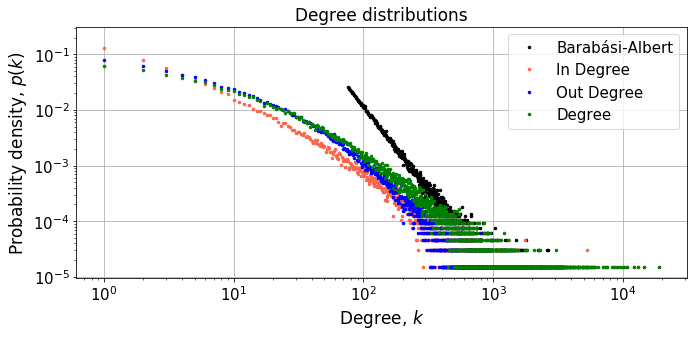

In [44]:
fig, ax = plt.subplots(figsize=FIGSIZE_TWOCOL)
MARKERSIZE=5

# random networks
#plt.plot(er_degree, er_degree_probs, '.', color='deeppink',   label=u'Erdős–Rényi', markersize = MARKERSIZE)
plt.plot(ba_degree, ba_degree_probs, '.', color='black',   label=u'Barabási-Albert', markersize = MARKERSIZE)

# real network
plt.plot(degree_in, in_degree_probs, '.', color='tomato',   label='In Degree', markersize = MARKERSIZE)
plt.plot(degree_out, out_degree_probs, '.', color='blue',   label='Out Degree', markersize = MARKERSIZE)
plt.plot(degree, degree_probs, '.', color='green',   label='Degree', markersize = MARKERSIZE)

"""
gamma_in_1 = regression(degree_in, in_degree_probs, 100,300, color="yellow").round(2)
gamma_in_2 = regression(ba_degree, ba_degree_probs, 100,300, color="yellow").round(2)
##plt.plot(range(0, len(hist)), hist, ".", color='deeppink',
##         label=u'Barabási–Albert')
print gamma_in_1
print gamma_in_2
"""

plt.grid()
plt.legend()
plt.title("Degree distributions")
plt.xlabel("Degree, $k$")
plt.ylabel("Probability density, $p(k)$")                                     
plt.loglog()
plt.tight_layout()
plt.savefig("imgs/degree_distributions.pdf")                                     

In [45]:
# regression testing
begin = 30
end = 200
counts_Y = np.log(in_degree_probs[begin:end])
degree_X = np.log(degree_in[begin:end]).astype(float)
degree_X=degree_X.reshape(end-begin,1)
regr = linear_model.LinearRegression()
regr.fit(degree_X, counts_Y)
count_pred = regr.predict(degree_X)+0.5

In [48]:
print regr.coef_[0]
print regr.intercept_
print regr.score(degree_X, counts_Y)

-1.64533850716
0.285776511621
0.95378108165


In [82]:
def regression(degree, degree_probs, begin, end, h_adjust=-0, color= "black"):
    """regression analysis between begin and end, 
    plotting of the line and returns the slope"""
    counts_Y = np.log(degree_probs[begin:end])
    degree_X = np.log(degree[begin:end]).astype(float)
    degree_X=degree_X.reshape(end-begin,1)
    regr = linear_model.LinearRegression()
    regr.fit(degree_X, counts_Y)
    count_pred = regr.predict(degree_X)+h_adjust
    plt.plot( np.exp(degree_X), np.exp(count_pred), color= color)
    return -regr.coef_[0]

## In-degree distribution

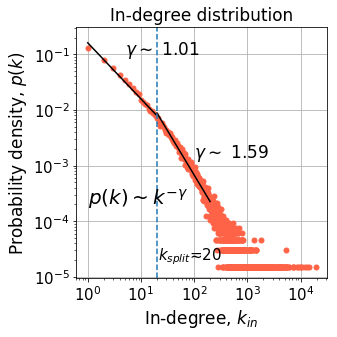

In [50]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(degree_in, in_degree_probs, '.', color='tomato',   label='In-degree', markersize = 10)
##plt.plot(degree_out, out_degree_probs, '.', color='green',   label='Original')

split =20
gamma_in_1 = regression(degree_in, in_degree_probs, 1,split).round(2)
gamma_in_2 = regression(degree_in, in_degree_probs, split,200).round(2)

plt.text(5, (float(1)/10), "$\gamma \sim $ {}".format(gamma_in_1))
plt.text(100,float(1)/700, "$\gamma \sim $ {}".format(gamma_in_2))
plt.text(1,float(1)/5000, "$p(k) \sim k^{-\gamma}  $ ",fontsize =20)
# info on the splitting
plt.axvline(split, 0,1000, linestyle='--')
plt.text(split+1, float(1)/50000, "$k_{split} \eqsim$"+"{}".format(20), fontsize=SMALL_SIZE)

plt.title("In-degree distribution")
plt.xlabel("In-degree, $k_{in}$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.tight_layout()
plt.savefig("imgs/in_degree_distribution.pdf")                                     

## Out-degree distribution

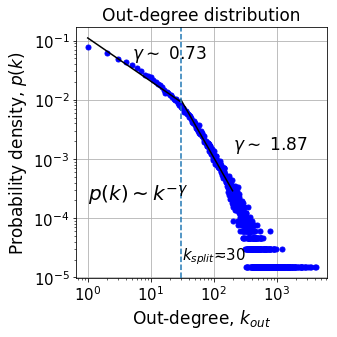

In [51]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
#fig, ax = plt.subplots(figsize = (20,10))
plt.plot(degree_out, out_degree_probs, '.', color='blue',   label='Out-degree', markersize = 10)
##plt.plot(degree_out, out_degree_probs, '.', color='green',   label='Original')

split =30
gamma_out_1 = regression(degree_out, out_degree_probs, 1,split).round(2)
gamma_out_2 = regression(degree_out, out_degree_probs, split, 200).round(2)

plt.text(5, (float(1)/20), "$\gamma \sim $ {}".format(gamma_out_1))
plt.text(200,float(1)/700, "$\gamma \sim $ {}".format(gamma_out_2))
plt.text(1,float(1)/5000, "$p(k) \sim k^{-\gamma}  $ ",fontsize =20)
# info on the splitting
plt.axvline(split, 0,1000, linestyle='--')
plt.text(split+1, float(1)/50000, "$k_{split} \eqsim$"+"{}".format(split), fontsize=SMALL_SIZE)

plt.title("Out-degree distribution")
plt.xlabel("Out-degree, $k_{out}$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.tight_layout()
plt.savefig("imgs/out_degree_distribution.pdf")                                     

# Connected components

In [9]:
print nx.is_strongly_connected(g)
print nx.is_weakly_connected(g)
print nx.is_strongly_connected(g_er)
print nx.is_weakly_connected(g_er)


print nx.is_connected(g_ba)

False
False


True
True
True

In [68]:
print nx.number_strongly_connected_components(g)
print nx.number_weakly_connected_components(g)

15757


62


In [ ]:
        print 'The Erdős–Rényi network is strongly connected with ' + \
            str(nx.number_strongly_connected_components(er_g)) + ' strongly ' \
            'connected components'
    elif nx.is_weakly_connected(er_g):
        print 'The Erdős–Rényi is weakly connected with ' + \
            str(nx.number_weakly_connected_components(er_g)) + \
            ' weakly connected components'
    else:
        print 'The Erdős–Rényi is neither strongly connected nor weakly ' + \
            'connected'

    if nx.is_connected(ba_g):
        print 'The Barabási–Albert network is connected with ' + \
            str(nx.number_connected_components(ba_g)) + \
            ' connected components'
    else:
        print 'The Barabási–Albert is not connected'


In [10]:
g_weak = collections.Counter(len(c)
                                 for c in nx.weakly_connected_components(g))
g_strong = collections.Counter(
        len(c)for c in nx.strongly_connected_components(g)
    )
er_weak = collections.Counter(len(c) for c in nx.
                                  weakly_connected_components(g_er))
er_strong = collections.Counter(len(c) for c in nx.
                                    strongly_connected_components(g_er))

In [11]:
er_weak

Counter({65729: 1})

In [29]:
x_weak = list(np.union1d(g_weak.keys(), er_weak.keys()))
x_strong = list(np.union1d(g_strong.keys(), er_strong.keys()))
y_weak = [g_weak[k] if k in g_weak else 0 for k in x_weak]
y_strong = [g_strong[k] if k in g_strong else 0 for k in x_strong]
y_weak_er = [er_weak[k] if k in er_weak else 0 for k in x_weak]

import copy
y_weak_lab = copy.copy(y_weak)
y_weak_lab[-1] =1

y_strong_lab = copy.copy(y_strong)
y_strong_lab[-1] =1


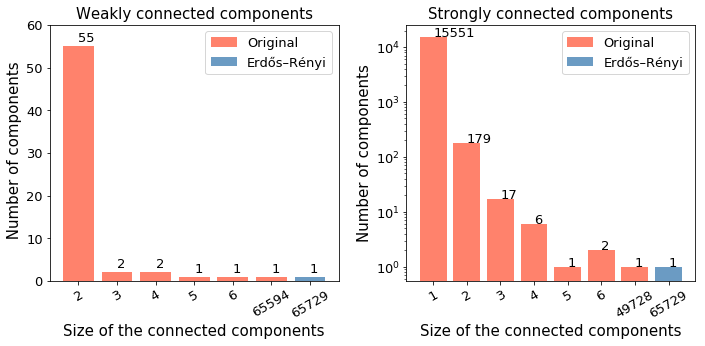

In [71]:
#plt.subplots(figsize = (10,10))
plt.subplots(figsize = FIGSIZE_TWOCOL)

plt.subplot(121)
plt.bar(range(len(x_weak)),y_weak,
            color='tomato', label='Original', alpha=.8)

for i in range(len(x_weak)):
    plt.text( i, y_weak_lab[i]+1, y_weak_lab[i] )

plt.bar(range(len(x_weak)), y_weak_er,
         color='steelblue', label=u'Erdős–Rényi', alpha=.8)
plt.xticks(range(len(x_weak)), x_weak, rotation = 30)
plt.title('Weakly connected components')
plt.xlabel('Size of the connected components')
plt.ylabel(' Number of components')
plt.legend()
plt.ylim(0,60)

plt.subplot(122)
plt.bar(range(len(x_strong)),
        [g_strong[k] if k in g_strong else 0 for k in x_strong],
        color='tomato', label='Original', log=True, alpha=.8)
plt.bar(range(len(x_strong)),
        [er_strong[k] if k in er_strong else 0 for k in x_strong],
        color='steelblue', label=u'Erdős–Rényi', log=True, alpha=.8)
for i in range(len(x_strong)):
    plt.text( i, y_strong_lab[i], y_strong_lab[i] )

plt.xticks(range(len(x_strong)), x_strong, rotation =30)
plt.title('Strongly connected components')
plt.xlabel('Size of the connected components')
plt.ylabel('Number of components')
plt.legend()

plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=1.4, wspace=0.2,
                    hspace=0.2)

plt.tight_layout()
plt.savefig('./imgs/connectivity.pdf', format='pdf')
